# Jonathan Gotian, Aarya Tavshikar, Jeanie Liu, Conor Mervyn

In [1]:
#import requests
#from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

**Research Question:** What is a better indicator of win probability across Elo ratings and time constraints: Opening played or Elo rating differential, or a combination of both? If both, what is the most accurate weighting for both Opening played and Elo rating differential to maximize win probability?

# Raw Data Observations and Attributes Legend

Each point, or observation, within the dataset consists of an individual chess game. The observations collected about each chess game include the following attributes:

* Event: The formal naming for this instance's time control variation
* Black: The Lichess username of the player using black pieces
* White: The Lichess username of the player using white pieces
* Result: The result of each game, denoted by '1-0' for White winning, '0-1' for Black winning, and '0.5-0.5' for a draw 
* UTCDate: The date in which the game was played
* UTCTime: The time in which the game was played
* WhiteELO: The Elo ratings for the white player
* BlackELO: The Elo ratings for the black player
* WhiteRatingDiff: How many points White gains/loses from the outcome of the game
* BlackRatingDiff: How many points Black gains/loses from the outcome of the game
* ECO: The Encyclopedia Chess Opening codes (which denotes the opening moves used by each player via a shorthand code)
* Opening: The full name of the played opening strategy
* Time Control: The Time Control for each game in seconds (time limits broken down into the format ‘Base Time + Increment’)
    * Base Time is the total base time given to each player for the entire game 
    * Increment is the additional time added to each player’s total time after each of their respective moves
* Termination: The Termination of each game (how each game was ended). The two main ones are:
    * Normal - a player was checkmated (left with no more moves)
    * Time forfeit - a player's base time reached 0 seconds before either player was able to complete the game
* AN: The exact moves each player did during the game

**Data Cleaning: Importing Data**

Here we imported raw data from a csv file that we downloaded from our Kaggle data source. This is stored inside the value chess_games. 

In [2]:
#Import raw data
chess_games = pd.read_csv('chess_games.csv')

**Data Cleaning: Column Types**

After inspecting the excel file, we realized that the UTCDate and UTCTime columns used strange formatting which would not convert properly into a dataframe. To rectify this, we coverted these columns to datetime. We also ran a test to confirm that the dtypes for other columns are expected. 

In [3]:
#Data Cleaning - convert date and time columns to datatime objects
chess_games['UTCDate'] = pd.to_datetime(chess_games['UTCDate'])
chess_games['UTCTime'] = pd.to_datetime(chess_games['UTCTime'])

display(chess_games.head())

#Check to ensure each column type is correct
print(chess_games.dtypes)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-12-09 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-12-09 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-12-09 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Correspondence,Jvayne,Wsjvayne,1-0,2016-06-30,2022-12-09 22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-12-09 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...


Event                      object
White                      object
Black                      object
Result                     object
UTCDate            datetime64[ns]
UTCTime            datetime64[ns]
WhiteElo                    int64
BlackElo                    int64
WhiteRatingDiff           float64
BlackRatingDiff           float64
ECO                        object
Opening                    object
TimeControl                object
Termination                object
AN                         object
dtype: object


**Data Cleaning: Termination Column**

The first column that we wanted to clean was the termination and results columns. In these columns, there were a couple of values which did not make sense in the context of the data. We also wanted to filter out terminations due to abandoned games, caused when one player suddenly quits, or rules infractions, caused when a player is found to be cheating. 

This cleaned data is stored in the value completed_chess_games

In [4]:
#filter out Termination = Abandoned, Rules infraction, filtering out TimeControl = '-'
#checking that there are no games where result is * (meaning incomplete)
completed_chess_games = %sql SELECT * FROM chess_games \
WHERE Termination NOT IN ('Abandoned', 'Rules infraction') \
    AND TimeControl != '-' \
    AND Result != '*'

**Data Cleaning: Removing Initial NaNs**

Here, we filtered out all the NaNs from the completed_chess_games dataset. 

In [5]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-12-09 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-12-09 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-12-09 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-12-09 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
4,Blitz tournament,lucaseixasouza,diguim,0-1,2016-06-30,2022-12-09 22:00:02,1773,1809,-10.0,10.0,C27,Vienna Game,180+0,Normal,1. e4 e5 2. Nc3 d6 3. Nf3 h6 4. Bc4 c6 5. b3 Q...


**Data Cleaning: Less Necessary Columns**

At this point, we realized that certain columns were useless to us. For example, it does not matter when games were played for our research, so we dropped these columns. Because our research looks at rating differentials, we calculated this value and stored it in a new column in the dataframe (WhiteRatingDiff). 

In [6]:
#Creating a new table filtering out unneccsary columns
#Creating a column WhiteRatingDiff for the rating differential between White and Black from white's perspective
completed_chess_games = %sql SELECT Event, Result, WhiteElo, BlackElo, (WhiteElo - BlackElo) AS WhiteRatingDiff, ECO, Opening, TimeControl, Termination \
FROM completed_chess_games

**Data Cleaning: Removing Additional NaNs**

Again, we had some NaNs in our dataframe under the WhiteRatingDiff column which arose due to the previous calculations. 

In [7]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination
0,Classical,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal
...,...,...,...,...,...,...,...,...,...
6215894,Blitz,1-0,1248,1303,-55,B54,Sicilian Defense,180+3,Normal
6215895,Classical,1-0,1328,1292,36,C40,King's Knight Opening,1800+0,Normal
6215896,Bullet,0-1,1660,1658,2,B21,Sicilian Defense: Smith-Morra Gambit,120+0,Normal
6215897,Bullet,0-1,1726,1776,-50,A09,Reti Opening: Reti Accepted,60+0,Normal


**Data Cleaning: Time Control**

Because our cleaned dataset of completed chess games was so large (~6.2 million rows), we decided to only take the top 10% of rows. 

We decided to use the top 10% of rows from the completed chess games as opposed to grouping by Opening, ELO Rating Differential, Time Control, or ELO Rating and taking the top 10% of rows from the group is that grouping the data by one variable can skew the distributions of the other variables in the data and in turn, skew the analysis of the data. It would not be a true random sample like taking the top 10% of rows.  

One of the final things to clean was the time control column. In chess, a time control is split into a base and an increment. The base denotes how much time you have to play the game and the increment denotes how much time is added to your remaining time per move you play. The standard notation for this is time control = base+increment. 

Here, we wanted to split the base and increment into their own columns to make the data easier to understand. After doing this, we joined the data from the time control rows with the data from the top 10% of rows. We then changed the units to make more sense, checked that the dtype for the new columns was correct, and saved this dataset into a new dataframe. 

In [8]:
#Sliced distribution - taking the top 10% of rows 
chess_games_cut = completed_chess_games[completed_chess_games['Event'].index <= len(completed_chess_games)*.10]

#spliting base and incremental into two different columns
#split the time control into two columns - Base and Incremental
time_control_df = chess_games_cut.TimeControl.apply(lambda x: pd.Series(str(x).split("+")))

time_control_df = time_control_df.rename(columns={0:"Base", 1:"Increment"})
display(time_control_df)

#Join chess games 10% cut df with time control split df together
chess_games_tc_split = pd.concat([chess_games_cut, time_control_df], axis=1)
print(chess_games_tc_split.dtypes)

#removing first column which has row numbers only
chess_games_tc_split = chess_games_tc_split.iloc[:,1:]

#converting 'Base' to minutes in floats and 'Increment' in ints
chess_games_tc_split['Base'] = chess_games_tc_split['Base'].astype(int) / 60
#chess_games_tc_split['Base'] = chess_games_tc_split['Base'] / 60
chess_games_tc_split['Increment'] = chess_games_tc_split['Increment'].astype(int)

#renaming Base and Increment columns with units
chess_games_tc_split = chess_games_tc_split.rename(columns = {'Base': 'Base (min)', 'Increment': 'Increment (sec)'})

#checking for data types of each column
print(chess_games_tc_split.dtypes)
display(chess_games_tc_split)

#saving a csv file of the cleaned data frame
#chess_games_tc_split.to_csv('chess_games_cleaned.csv')

,Base,Increment
0,300,5
1,300,0
2,180,0
3,180,0
4,180,0
...,...,...
621585,60,0
621586,300,0
621587,300,4
621588,180,0


Event              object
Result             object
WhiteElo            int64
BlackElo            int64
WhiteRatingDiff     int64
ECO                object
Opening            object
TimeControl        object
Termination        object
Base               object
Increment          object
dtype: object
Result              object
WhiteElo             int64
BlackElo             int64
WhiteRatingDiff      int64
ECO                 object
Opening             object
TimeControl         object
Termination         object
Base (min)         float64
Increment (sec)      int64
dtype: object


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec)
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0
621586,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0
621587,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4
621588,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0


# Data Sample Distribution Testing 
**Data Testing: Opening Distributions**

Because we sliced to only include the top 10% of rows, we wanted to ensure that the data was relatively similar, specifically in the distributions of openings. We did this by comparing the number of occurances of each opening before and after our slice, as well as the percentage of the total that these openings were. We then compared the difference in percentage of the density of these openings before and after our split, creating a new column Percent_Diff in a new joined table. 

As shown in the resulting table, some openings which were only played in games that were sliced did not show up after the slice happened. These resulted in NaN values for Cut_Count, Cut_Percent_Tot, and Percent_Diff. 

Given that the percent difference was so small between the sliced and original dataset, we can assume that our slice is accurate at representing our original dataset. 

In [9]:
#TESTING DISTRIBUTIONS - OPENING
#Opening distribution - pre slice
#Group by opening, and count each occurance of the opening
opening_dist = completed_chess_games.groupby(by = 'Opening')
opening_dist = opening_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
opening_dist_1 = opening_dist.loc[:, ['Event']]
opening_dist_1 = opening_dist_1.rename(columns={"Event":"Count"}) #renaming column 'Event' to 'Count'
opening_dist_1['Percent_Tot'] = opening_dist_1['Count']/len(completed_chess_games)
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
opening_dist_1 = opening_dist_1[opening_dist_1['Percent_Tot'] > 0.0001]

#2940 rows - no filter for > 0.01% of Total
#958 rows - filter for > 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
opening_dist_cut = chess_games_cut.groupby(by = 'Opening')
opening_dist_cut = opening_dist_cut.count().sort_values(by = 'Event', ascending=False)
#opening_dist_cut

#Calculate the percent of total occurances for each opening 
opening_dist_cut_1 = opening_dist_cut.loc[:, ['Event']]
opening_dist_cut_1 = opening_dist_cut_1.rename(columns={"Event":"CUT_Count"})
opening_dist_cut_1['CUT_Percent_Tot'] = opening_dist_cut_1['CUT_Count']/len(chess_games_cut) #renaming column 'Event' to 'Count'
opening_dist_cut_1 = opening_dist_cut_1[opening_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
#opening_dist_cut_1

#2623 rows - no filter for > 0.01% of Total
#956 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
open_joined = opening_dist_1.join(opening_dist_cut_1, on = "Opening")
open_joined['Percent_Diff'] = open_joined['Percent_Tot'] - open_joined['CUT_Percent_Tot']
open_joined
#958 rows with NaN included
#924 rows NaN filtered out

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
Opening,,,,,
Van't Kruijs Opening,131980,0.021233,13161.0,0.021173,0.000060
Scandinavian Defense: Mieses-Kotroc Variation,111905,0.018003,11614.0,0.018684,-0.000681
Modern Defense,107921,0.017362,10334.0,0.016625,0.000737
Horwitz Defense,95189,0.015314,9408.0,0.015135,0.000178
Sicilian Defense,85206,0.013708,8881.0,0.014288,-0.000580
...,...,...,...,...,...
"French Defense: Winawer Variation, Winckelmann-Riemer Gambit",628,0.000101,NaN,NaN,NaN
Caro-Kann Defense: Gurgenidze System,627,0.000101,NaN,NaN,NaN
Zukertort Opening,625,0.000101,69.0,0.000111,-0.000010


**Data Testing: ELO Rating Differential Distributions**

To reaffirm that our split for our random sample was successful at representing the original dataset, we decided to create histograms of the rating differentials in the dataset before and after the split. 

These distributions look the same, so we can reaffirm that the cut was successful based on rating differential. 

array([[<AxesSubplot: title={'center': 'WhiteRatingDiff'}>]], dtype=object)

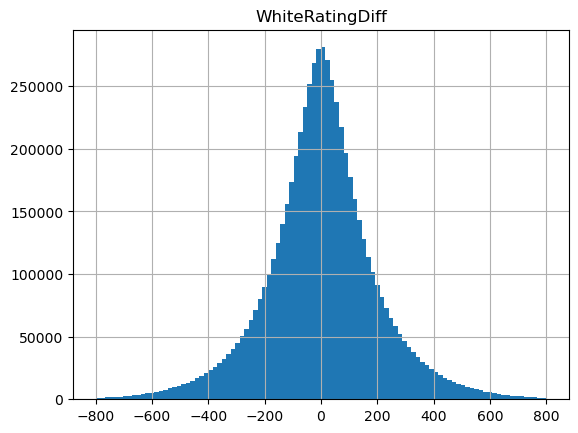

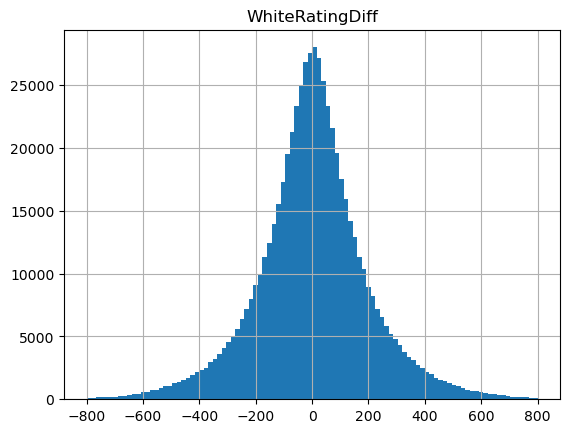

In [10]:
#TESTING DISTRIBUTIONS - RATING DIFFERENTIAL 
#TOP = Distribution of Original DF
completed_chess_games.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Bottom = Distribution of Cut DF
chess_games_cut.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Distributions look the same so good cut based on Rating Differential

**Data Testing: ELO Rating Distribution**

Another way to validate if our data is properly distributed is to inspect rating distributions. Specifically, this would tell us if both datasets contain players of the same rating range. 

The histograms for both black and white's ELO rating looks the same between the datasets before and after slicing. Thus, we can assume that the cut was successful based on rating. 

array([[<AxesSubplot: title={'center': 'WhiteElo'}>,
        <AxesSubplot: title={'center': 'BlackElo'}>]], dtype=object)

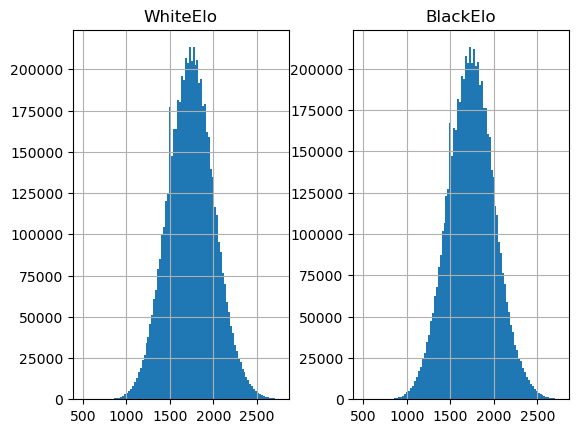

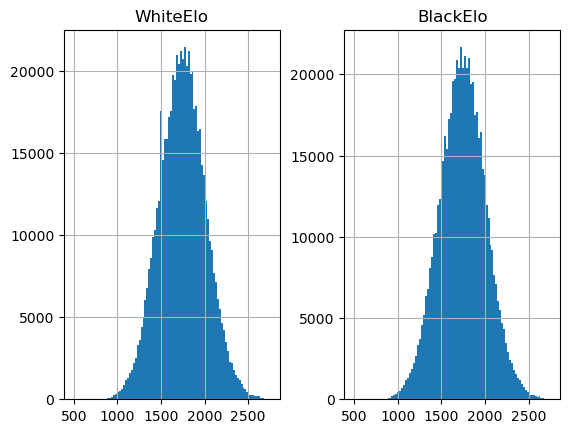

In [11]:
#TESTING DISTRIBUTIONS - RATING  
#TOP = Distribution of Original DF
completed_chess_games.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))

#BOTTOM = Distribution of Cut DF
chess_games_cut.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))


#Distributions look the same so good cut based on Rating

**Data Testing: Time Control Distributions**

As we did previously, we wanted to ensure that the data was relatively similar, specifically in the distributions of time controls. We did this by comparing the number of occurances of each time control before and after our slice, as well as the percentage of the total that these controls were. We then compared the difference in percentage of the density of these controls before and after our split, creating a new column Percent_Diff in a new joined table. 

As shown in the resulting table, some controls which were only played in games that were sliced did not show up after the slice happened. These resulted in NaN values for Cut_Count, Cut_Percent_Tot, and Percent_Diff. 

Given that the percent difference was so small between the sliced and original dataset, we can assume that our slice is accurate at representing our original dataset. 

In [12]:
#TESTING DISTRIBUTIONS - TIME CONTROL
#Time Control distribution - pre slice
#Group by Time Control, and count each occurance of the Control
timecontrol_dist = completed_chess_games.groupby(by = 'TimeControl')
timecontrol_dist = timecontrol_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
timecontrol_dist_1 = timecontrol_dist.loc[:, ['Event']]
timecontrol_dist_1 = timecontrol_dist_1.rename(columns={"Event":"Count"})
timecontrol_dist_1['Percent_Tot'] = timecontrol_dist_1['Count']/len(completed_chess_games)
timecontrol_dist_1 = timecontrol_dist_1[timecontrol_dist_1['Percent_Tot'] > 0.0001]

#840 rows - no filter for 0.01% of Total
#189 rows - filter for 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
timecontrol_dist_cut = chess_games_cut.groupby(by = 'TimeControl')
timecontrol_dist_cut = timecontrol_dist_cut.count().sort_values(by = 'Event', ascending=False)
timecontrol_dist_cut

#Calculate the percent of total occurances for each opening 
timecontrol_dist_cut_1 = timecontrol_dist_cut.loc[:, ['Event']]
timecontrol_dist_cut_1 = timecontrol_dist_cut_1.rename(columns={"Event":"CUT_Count"})
timecontrol_dist_cut_1['CUT_Percent_Tot'] = timecontrol_dist_cut_1['CUT_Count']/len(chess_games_cut)
timecontrol_dist_cut_1 = timecontrol_dist_cut_1[timecontrol_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
timecontrol_dist_cut_1

#534 rows - no filter for > 0.01% of Total
#182 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
tc_joined = timecontrol_dist_1.join(timecontrol_dist_cut_1, on = "TimeControl")
tc_joined['Percent_Diff'] = tc_joined['Percent_Tot'] - tc_joined['CUT_Percent_Tot']
tc_joined

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
TimeControl,,,,,
300+0,1071549,0.172388,106906.0,0.171988,0.000400
180+0,945369,0.152089,94972.0,0.152789,-0.000700
60+0,909552,0.146327,92614.0,0.148995,-0.002669
600+0,576641,0.092769,58983.0,0.094891,-0.002122
30+0,306403,0.049293,23946.0,0.038524,0.010770
...,...,...,...,...,...
660+7,651,0.000105,82.0,0.000132,-0.000027
300+9,651,0.000105,NaN,NaN,NaN
540+10,641,0.000103,NaN,NaN,NaN


# Data Description

### Motivation

**For what purpose was the dataset created?**

This dataset was created to analyze our research question which looks at if elo rating differential or time control is a better indicator of win probability. 

**Who funded the creation of the dataset?**

The funding for the original dataset is unknown at this time, but all data was published by lichess.org. Lichess is a free, open-source, non-profit organization. 

### Composition:

**What do the instances that comprise the dataset represent?**

Instances of the data represent individual games played on the lichess platform. 

**How many instances are there in total?**

The data includes approximately 620,000 individual games.

**Does the dataset contain all possible instances or is it a sample of instances from a larger set?**

The dataset does not include all possible instances, as we chose to only include 10% of the instances from the larger raw dataset extracted from Kaggle. Additionally, because the data was collected over a brief period of time using only one online platform, it is not immediately clear if it is representative of all chess games played. 

We conducted statistical analyses, checking if the difference in densities for openings played and time controls was different between our dataset and the larger dataset. These analyses found no noticeable differences, ensuring that our dataset was representative of the larger set. 

**What are the observations (rows) and the attributes (columns)?**

***Columns:***

* Result: The result of each game, denoted by '1-0' for White winning, '0-1' for Black winning, and '0.5-0.5' for a draw. 
WhiteElo: The ELO rating for the player using white pieces

* BlackElo: The ELO rating for the player using black pieces

* WhiteRatingDiff: The ELO rating differential from the perspective of the player using white pieces. 

* ECO: The Encyclopedia Chess Opening codes which denotes the opening moves used by each player via a shorthand code. 

* Opening: The full name of each opening strategy, a pattern of moves a player uses to open the game. 

* Time Control: The time limit for each game in seconds (time limits broken down into the format ‘Base Time + Increment’)

* Termination: The Termination of each game (how each game was ended). The two main ones are:
    * Normal - a player was checkmated (left with no more moves)
    * Time forfeit - a player's base time reached 0 seconds before either player was able to complete the game

* Base Time is the total base time given to each player for the entire game

* Increment is the additional time added to each player’s total time after each of their respective moves

***Rows:***

Each row represents an individual game

**Is any information missing from individual instances?**
No. Data was cleaned such that each instance is complete. 

**Is the dataset self-contained or does it link to or otherwise rely on external resources?**
Yes, the dataset is self-contained. Although the data was extracted from an online chess platform, our collection of data will remain static. 

### Collection Process

**How was the data associated with each instance acquired?**
The data was collected from lichess, but it is not directly clear where on lichess this data came from. 

**Over what timeframe was the data collected?**
Per the data description on Kaggle, the data was collected over all chess games played on Lichess in July of 2016. 

**Did you collect data from individuals in question directly or obtain it via third parties or other sources?**
Our data does collect information about people, as each chess player is associated with an actual person. The data was not collected from these individuals directly, but was obtained from Lichess, the platform where they played chess. 

**Were the individuals in question notified about the data collection, and if so, what purpose did they expect the data to be used for?**
Yes, Lichess does explicitly notify individuals of data collection for statistical purposes, as outlined in their privacy policy:

“In order to maintain statistics relating to the games that took place on the lichess.org site and in particular to allow you to know your history of the games played as well as your ranking, we will keep your username and other non-personal information, such as party metadata.
This further processing is compatible with the initial collection of your username, justified by the execution of the contract in accordance with Article 6.1.b of the GDPR as indicated in point 2 above, in accordance with recital 50 and Articles 5 and 89 of the GDPR.”
    
As indicated in the above privacy policy, individuals expected their data to be used for statistical purposes, which falls within the bounds of this project. 

### Preprocessing/cleaning/labeling

**Was any preprocessing/cleaning/labeling of the data done?**
Yes, the data was taken from a relatively raw format and preprocessed to be analyzable. This involved a couple of steps. First, we shrunk down the data into 10% of its original size, in order to make our analysis more efficient. We also worked to clean some columns, removing instances where columns had unexpected or invalid values, such as termination due to cheating or abandonment. We compared our preprocessed data to the raw dataset, ensuring that our preprocessed data was not noticeably different. 

**Was the “raw” data saved in addition to the preprocessed/cleaned/labeled data?**
Yes. A link to this data is below:
https://cornell.box.com/s/tey4tig1xn8ngpml1x0c866nvkz65jkj

### Uses
**Has the dataset been used for any tasks already?**
Yes. The dataset has been used to quantify high-level summary statistics and draw charts including histograms, density charts, and bar charts. These summary diagrams have given us some insight into the dataset. 
**What (other) tasks could the dataset be used for?**
The dataset will be used to run more complicated statistical testing, including a hypothesis test, to better quantify our research question. 


# Data Limitations

There are a couple of obvious limitations to our raw and analysis-ready dataset. The first limitation comes from the source of our data. Specifically, because this is data collected for all games played on the Lichess platform during July 2016, it cannot be said to be representative of all games played on Lichess, or even all games played on chess platforms on the internet. More specifically, there are other massively popular online chess websites (chess.com or chess24.com, etc.) which also have millions of games played every month. 

This is further amplified by the fact that a large number of chess games aren’t played online, and no data exists for them. Some data exists for in-person chess games, but these are usually limited to tournaments, and don’t usually account for amateur players or other over-the-board games. 

Another limitation of our data relates to our Termination values. There were four unique values here, ‘Abandoned’, ‘Time forfeit’, ‘Normal’, and ‘Rules Infraction’. Rules Infraction was used to denote games where one player was found to be cheating, based on if they were playing suspiciously above a human level. One limitation of this data is that players could have cheated on games but not been caught by the Lichess platform. This is a relatively common occurrence, and can add noise to data on game results. 


# Summary and Descriptive Stats

Here, we changed the name of the dataframe to chess_games for simplicity.

In [13]:
chess_games = chess_games_tc_split
print(display(chess_games))

,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec)
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0
621586,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0
621587,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4
621588,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0


None


**Computing Win Rates of Each Opening**

As part of our research question is about predicting win probability with opening played, we computed the win rate of each opening. We first tallied the number of games played for each opening in a data frame and then tallied the number of games won for each opening in another data frame.  We then joined the 2 data frames by opening.

Since there were openings with no games won, joining the two data frames resulted in NaNs in the Games_Won column. We thus dropped all NaNs.

Because we did not want openings that were played infrequently to seemingly have high win rates, we dropped all openings that had fewer than 50 games played.

Finally, we computed the win rate by dividing Games_Won by Games_Played and dropped the Games_Won and Games_Played columns.


In [14]:
#adding win rate column for each opening

#all openings with corresponding number of games played
%sql opening_games_played << SELECT Opening, COUNT(ECO) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC

print(opening_games_played)

#all openings with corresponding number of games won
%sql opening_games_won << SELECT Opening, COUNT(ECO) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC

print(opening_games_won)

#joining games played and games won by opening
%sql opening_games << SELECT opening_games_played.Opening, Games_Played, Games_Won \
FROM opening_games_played LEFT JOIN opening_games_won \
ON opening_games_played.Opening = opening_games_won.Opening ORDER BY Games_Played DESC

#drop NaNs --> NaNs in Games_Won column indicate that opening has 0 games won
opening_games.dropna()

#filter for openings that have at least 50 games played
opening_games = opening_games[opening_games['Games_Played'] >= 50]

#compute win rate column and sort by win rate
opening_games['Win_Rate'] = opening_games['Games_Won'] / opening_games['Games_Played']
opening_win_rate = opening_games.sort_values(by = ['Win_Rate'], ascending = False)

#drop columns Games_Played and Games_Won; rename Opening to Opening_Type for later merging
opening_win_rate = opening_win_rate.drop(columns = ['Games_Played', 'Games_Won'])
opening_win_rate = opening_win_rate.rename(columns={'Opening': 'Opening_Type'})

display(opening_win_rate)

Returning data to local variable opening_games_played
                                                Opening  Games_Played
0                                  Van't Kruijs Opening         13161
1         Scandinavian Defense: Mieses-Kotroc Variation         11614
2                                        Modern Defense         10334
3                                       Horwitz Defense          9408
4                                      Sicilian Defense          8881
...                                                 ...           ...
2618  Catalan Opening: Open Defense, Modern Sharp Va...             1
2619  Ruy Lopez: Old Steinitz Defense: Semi-Duras Va...             1
2620  Pterodactyl Defense: Central, Quetzalcoatlus G...             1
2621  Nimzowitsch Defense: El Columpio Defense, Exch...             1
2622  King's Indian Defense: Fianchetto Variation, P...             1

[2623 rows x 2 columns]
Returning data to local variable opening_games_won
                              

,Opening_Type,Win_Rate
614,"Italian Game: Two Knights Defense, Knight Attack",0.790850
932,Indian Game: Normal Variation,0.772727
736,"Italian Game: Two Knights Defense, Max Lange A...",0.735849
946,Scandinavian Defense: Anderssen Counterattack,0.734375
880,Italian Game: Scotch Gambit Declined,0.733333
...,...,...
1048,Nimzowitsch Defense: Scandinavian Variation,0.326923
685,"Queen's Pawn Opening: Veresov, Richter Attack",0.322314
70,King's Pawn Game,0.321090
805,"Sicilian Defense: Sozin Attack, Leonhardt Vari...",0.311111


**Appending win probability to the list of all chess games**

Using the data frame with each opening and its corresponding win rate, we appended the win probability to each chess game played according to the opening played. Since we had fewer openings with win rates after filtering to at least 50 games played,  we used an inner join to avoid NaNs for chess games that had openings that were not in the list of openings with win rates data frame. 


In [15]:
#adding win rate to individual games data frame
%sql chess_games_rate << SELECT * FROM chess_games INNER JOIN opening_win_rate \
ON chess_games.Opening = opening_win_rate.Opening_Type

chess_games_rate = chess_games_rate.drop(columns = ['Opening_Type'])
display(chess_games_rate)

Returning data to local variable chess_games_rate


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec),Win_Rate
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5,0.490376
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0,0.412060
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0,0.558550
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0,0.444695
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0,0.579278
...,...,...,...,...,...,...,...,...,...,...,...
601600,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0,0.480550
601601,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0,0.457798
601602,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4,0.539982
601603,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0,0.450352


**Descriptive Statistics**

For our next steps, we would like to see whether opening played or rating differential is a better predictor of win probability at different Elo ratings and time constraints. Thus, performing descriptive statistics and seeing the distribution of Elo ratings and time constraints would help us divide them into multiple ranges.  

In [16]:
#statistical summary of the chess games along with win rates
display(chess_games_rate.describe())

,WhiteElo,BlackElo,WhiteRatingDiff,Base (min),Increment (sec),Win_Rate
count,601605.000000,601605.000000,601605.000000,601605.000000,601605.000000,601605.000000
mean,1739.926684,1738.688520,1.238165,5.279337,1.203029,0.496204
std,262.636378,264.311847,202.510357,6.657565,4.180337,0.056518
min,784.000000,728.000000,-1569.000000,0.000000,0.000000,0.287879
25%,1559.000000,1557.000000,-105.000000,2.000000,0.000000,0.458476
50%,1740.000000,1738.000000,1.000000,4.000000,0.000000,0.491758
75%,1916.000000,1916.000000,107.000000,6.000000,1.000000,0.533439
max,3006.000000,3069.000000,1469.000000,180.000000,180.000000,0.790850


**Most Popular Openings and Best Openings by Win Rate**

We graphed the top 10 played openings and found that van't kruijs opening is the most popular opening by a huge margin with over 12,000 games played. The other 9 popular openings have at least 7000 games played to over 11,000 games played. 

We also graphed the top 10 openings by their win rate. These openings have win rates in the range of 0.7 and 0.8. 


Returning data to local variable top_ten_popular_openings
Returning data to local variable top_ten_openings_rate


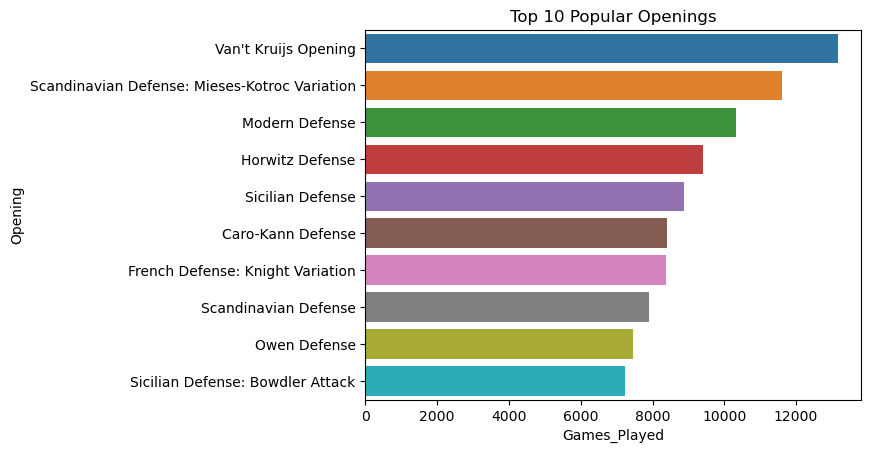

[Text(0.5, 1.0, 'Top 10 Openings by Win Rate')]

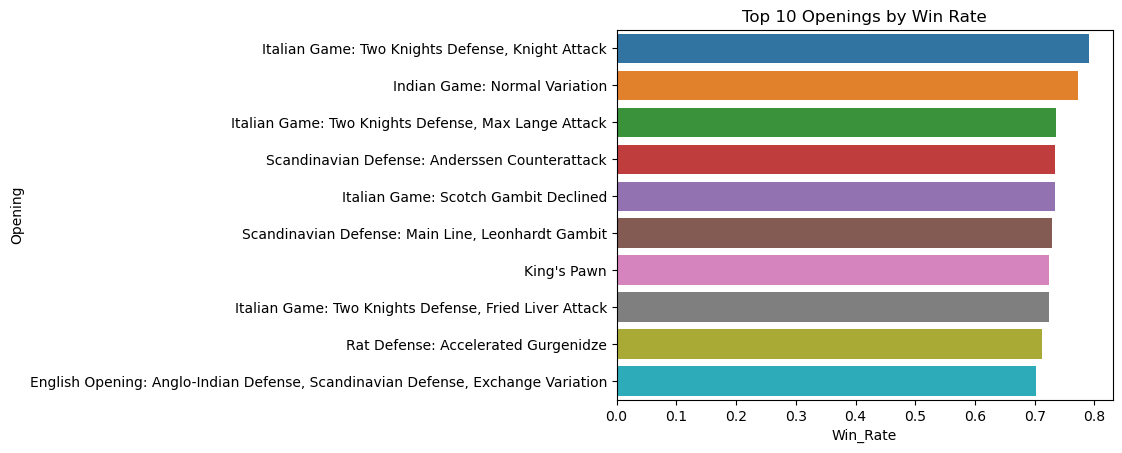

In [17]:
#Top 10 popular openings & top 10 openings by win rate
%sql top_ten_popular_openings << SELECT Opening, COUNT(ECO) As Games_Played \
FROM chess_games_rate GROUP BY Opening ORDER BY Games_Played DESC LIMIT 10
%sql top_ten_openings_rate << SELECT * FROM opening_games ORDER BY Win_Rate DESC LIMIT 10

#plotting the top 10 popular openings & openings by win rate
seaborn.barplot(data = top_ten_popular_openings, x = 'Games_Played', y = 'Opening').set(title = 'Top 10 Popular Openings')
pyplot.show()
seaborn.barplot(data = top_ten_openings_rate, x = 'Win_Rate', y = 'Opening').set(title = 'Top 10 Openings by Win Rate')

**Worse Openings by Win Rate**

Since we limited openings to those having at least 50 games played, graphing the least 10 popular openings was not meaningful as they all just have 50 games played. Hence, we graphed the bottom 10 openings by win rate only. We found that the worse openings have win rates that fall between 0.28 and 0.34. 


Returning data to local variable bottom_ten_openings_rate
Returning data to local variable bottom_ten_openings_rate


[Text(0.5, 1.0, 'Bottom 10 Openings by Win Rate')]

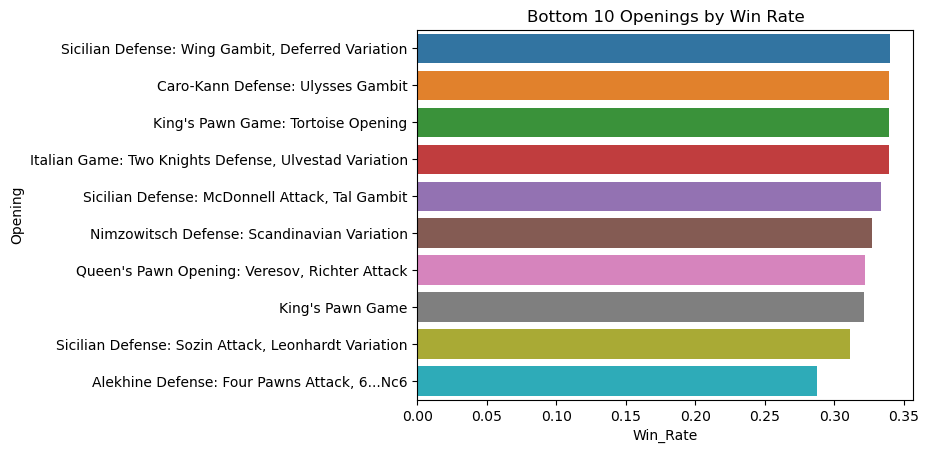

In [18]:
#bottom 10 openings by win rate
%sql bottom_ten_openings_rate << SELECT * FROM opening_games ORDER BY Win_Rate LIMIT 10
%sql bottom_ten_openings_rate << SELECT * FROM bottom_ten_openings_rate ORDER BY Win_Rate DESC

#plotting the bottom 10 openings by win rate
seaborn.barplot(data = bottom_ten_openings_rate, x = 'Win_Rate', y = 'Opening').set(title = 'Bottom 10 Openings by Win Rate')

**Plotting histograms**

We plotted histograms on rating differential, time control variables, termination type, and win rate so that we could see their distributions.

We found that the rating differential is normally distributed with a mean of 0. This means the majority of chess games played had players that were at similar skill levels. 

We further found that most chess games were played at 1, 3, 5, 10 minute bases. This is not surprising since these are the preset time bases in lichess. 

Most games were played with 0 increment. 

Around 2/3 of the games had normal terminations. 1/3 had time forfeit terminations, meaning they ran out of time. 

Lastly, win rates ranged from a little bit less than 0.3 to a little bit less than 0.8, but most had win rates of 0.45 to 0.55.


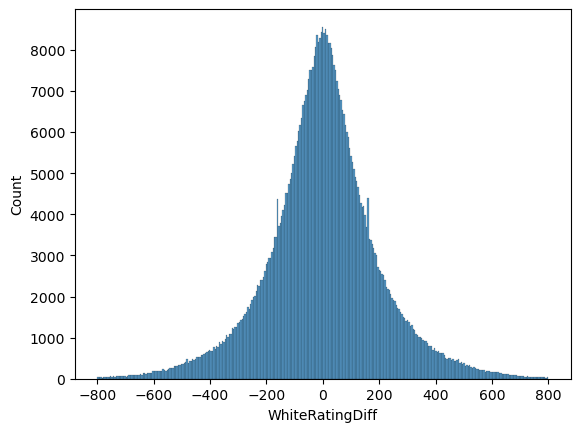

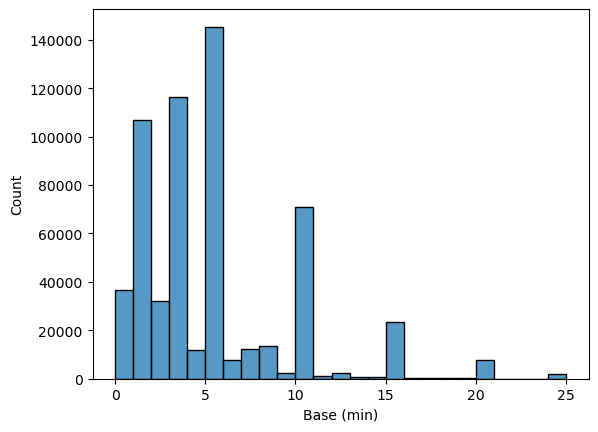

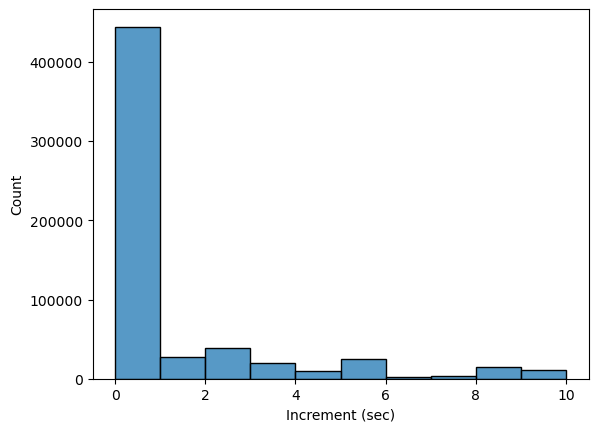

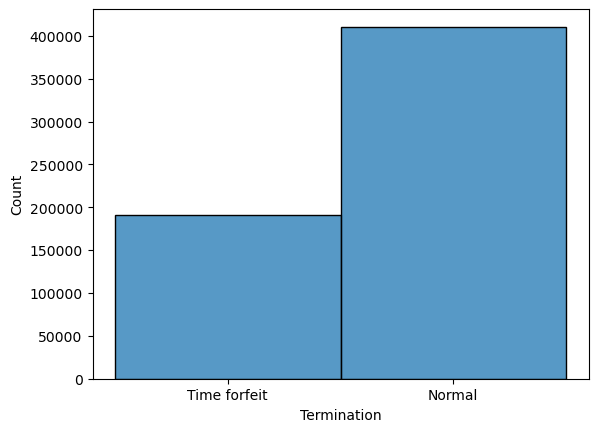

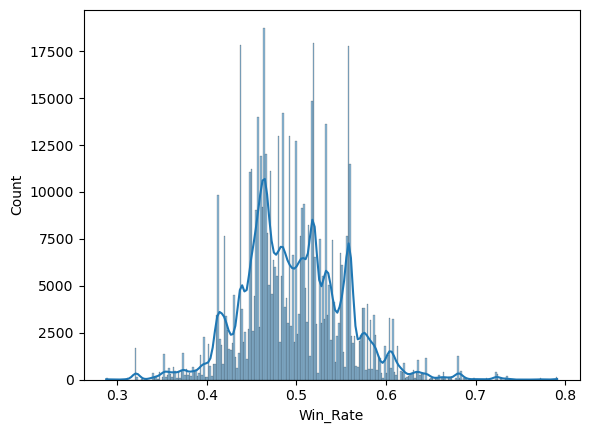

In [19]:
#histograms to help us see distributions of rating differential, time control variables, termination type, and win rate
seaborn.histplot(data = chess_games_rate, x = 'WhiteRatingDiff', binrange = (-800,800))
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Base (min)', binrange = (0,25), binwidth = 1)
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Increment (sec)', binrange = (0,10), binwidth = 1)
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Termination')
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Win_Rate', kde = True)
pyplot.show()

**Plotting Scatterplots**

We plotted rating differential against win rates to see if there is a relationship between the two. The two variables do not seem to have an apparent relationship, but further analysis is needed. 

We also found that regardless of the base, all the win rates are centered around 0.5. Some bases like those in the range of 0 to 30 min, 60 min, 90 min, and 180 min seem to have greater spread of win rates, but this is most likely due to having more games that are played at these preset bases. Similarly, win rates are centered around 0.5 at different increments. Increments of 0 - 30 sec, 60 sec, 90 sec, and 180 sec have wide spread of win rates. 


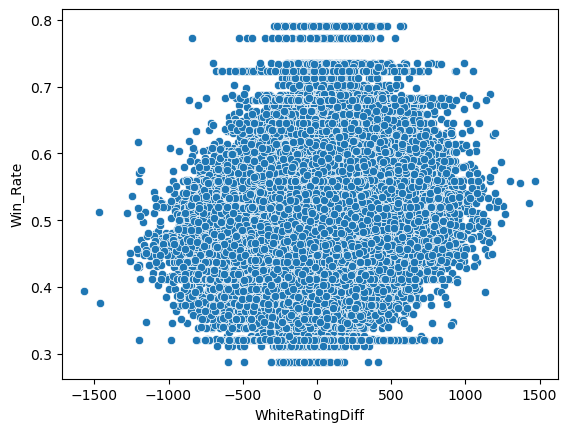

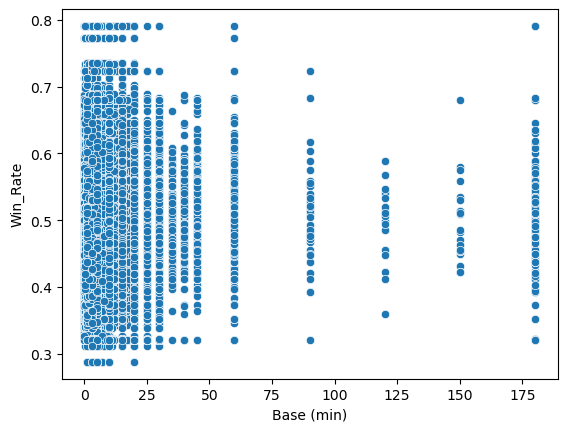

<AxesSubplot: xlabel='Increment (sec)', ylabel='Win_Rate'>

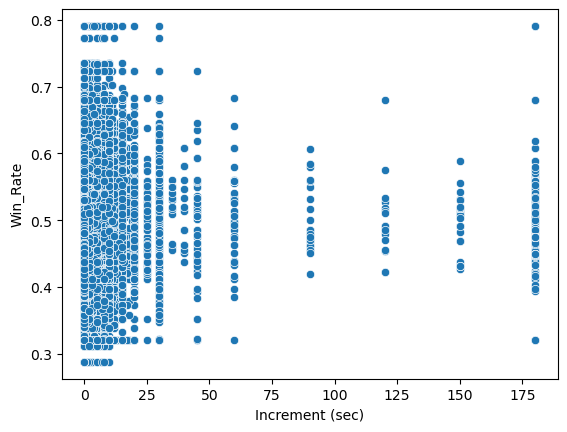

In [20]:
#scatterplots to see relationship between rating differential and win rate vs. base time control and win rate
seaborn.scatterplot(data = chess_games_rate, x = 'WhiteRatingDiff', y = 'Win_Rate')
pyplot.show()
seaborn.scatterplot(data = chess_games_rate, x = 'Base (min)', y = 'Win_Rate')
pyplot.show()
seaborn.scatterplot(data = chess_games_rate, x = 'Increment (sec)', y = 'Win_Rate')

**Correlation between rating differential and win rate**

In our scatterplot, we found no apparent relationship between rating differential and win rate. Thus, we computed the correlation between the two.
The correlation is 0.16, which is a rather weak positive linear relationship. 

In [21]:
#correlation between Elo rating differential and win rate
display(chess_games_rate[['WhiteRatingDiff','Win_Rate']].corr())

,WhiteRatingDiff,Win_Rate
WhiteRatingDiff,1.000000,0.161571
Win_Rate,0.161571,1.000000


# Questions

1. Why shouldn't we try to convert opening win probability into a logarithmic function?

2. What's the best way to compare the discrete variable of opening to the continuos variable of rating differential in their effect on win probability?

3. How do we calculate which weighting of the two variables is ideal for determining win probability?

4. How much background about chess should we include in our final summary?

5. Is our reasoning for cutting openings to the top 10% sufficient in making sure that the cut is representative of the sample dataset?

6. How do we decrease run times to still provide a meaningful statistical analysis with a large amount of data?

# Next Steps

We have two major next steps as part of our analysis. First, because we want to run statistics on the opening, which is a discrete variable, we wanted some way to quantify their impact on win probability. Our immediate solution is to use dummy variables to represent and analyze these openings. We also want to calculate the specific weighting of ELO differential and time control which can predict win probability, which will require special calculations. We considered multiplying an opening’s win probability by 1 or -1 based on if the opening is better/worse than the average opening in terms of win probability. We wanted to graph this logarithmically to see which openings were better/worse on average compared to others, attempting to quantify the discrete opening variable. We decided not to do this upon advice from the teaching staff. 
